<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product
#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
base_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_path = os.path.join(base_path, "SFA")

@timeout_decorator.timeout(40)# Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

In [2]:
[board,profile_path,number_of_chips]=obtain_board()

<font size=8> SWEEP

In [5]:
import numpy as np
import os
neuron_config=neuron_configs_bio.config()

neuron_config['SST_W0']=[2,150]#input weight to PC
neuron_config['SST_W1']=[4,200]#PC to SST weight
neuron_config['SST_W2']=[0,50]#PV shunt inhibition to SST

neuron_config['SST_AMPA_GAIN']=[1,100]
neuron_config['SST_AMPA_TAU']=[1,10]
neuron_config['SST_LEAK']=[0,10]

neuron_config['Input_SST']=.2#.1#.1

neuron_config['PC_SST']=.1#.1

neuron_config['PC_Adaptation']=True
neuron_config['duration']=1
neuron_config['input_type']='Poisson'
neuron_config['in_freq']=20

# Path to save the simulation data
save_directory_path = os.path.join(base_path, "recurrent_sweep")
data_path = os.path.join(save_directory_path, "simulation_data.npy")

#input frequencies and conneciton ratiors
input_frequencies=np.arange(1,21,1)
connection_ratios=np.arange(0,.7,.1)

# Check if the data file exists
if os.path.exists(data_path):
    # Load existing data
    simulation_data = np.load(data_path, allow_pickle=True).item()
else:
    if not os.path.exists(data_path):
        # If not, initialize with NaNs for every combination
        simulation_data = {
            "cv_values_pc": [np.nan] * len(input_frequencies) * len(connection_ratios),
            "cv_values_pv": [np.nan] * len(input_frequencies) * len(connection_ratios),
            "synchrony_values_pc": [np.nan] * len(input_frequencies) * len(connection_ratios),
            "synchrony_values_pv": [np.nan] * len(input_frequencies) * len(connection_ratios),
            "mean_pc_rates": [np.nan] * len(input_frequencies) * len(connection_ratios),
            "input_frequencies": np.arange(1, 21, 1),
            "connection_ratios": np.arange(0, .7, .1)
        }

def contains_nan(input_freq, connection_ratio):
    input_idx = np.argmin(np.abs(np.array(simulation_data["input_frequencies"]) - input_freq))
    conn_idx = np.argmin(np.abs(np.array(simulation_data["connection_ratios"]) - connection_ratio))
    
    index = len(simulation_data["connection_ratios"]) * input_idx + conn_idx
    
    return np.isnan(simulation_data["cv_values_pc"][index]) or \
           np.isnan(simulation_data["cv_values_pv"][index]) or \
           np.isnan(simulation_data["synchrony_values_pc"][index]) or \
           np.isnan(simulation_data["synchrony_values_pv"][index]) or \
           np.isnan(simulation_data["mean_pc_rates"][index])


for input_freq in simulation_data["input_frequencies"]:
    neuron_config['input_frequency'] = input_freq
    for connection_ratio in simulation_data["connection_ratios"]:
        # Only run the simulation if the data for this configuration contains NaN values
        if contains_nan(input_freq, connection_ratio):
            neuron_config['PC_PC'] = connection_ratio
            try:
                [output_events, test_config] = run_simulation(neuron_config)

                cv_temp, synchrony_temp = run_dynamic_anal(output_events, test_config)

                rates = spike_count(output_events=output_events)
                PC_rates, _, _ = pop_rates(rates, test_config)

                # Update the results in the loaded/initialized data
                index = len(simulation_data["connection_ratios"]) * list(simulation_data["input_frequencies"]).index(input_freq) + list(simulation_data["connection_ratios"]).index(connection_ratio)
                simulation_data["cv_values_pc"][index] = cv_temp[0]
                simulation_data["cv_values_pv"][index] = cv_temp[1]
                simulation_data["synchrony_values_pc"][index] = synchrony_temp[0]
                simulation_data["synchrony_values_pv"][index] = synchrony_temp[1]
                simulation_data["mean_pc_rates"][index] = np.mean(PC_rates)
            except timeout_decorator.TimeoutError:
                print("Simulation timed out for input frequency %d and connection ratio %.2f" % (input_freq, connection_ratio))
                index = len(simulation_data["connection_ratios"]) * list(simulation_data["input_frequencies"]).index(input_freq) + list(simulation_data["connection_ratios"]).index(connection_ratio)
                # You might want to update the corresponding values to NaN if timeout occurs. Depends on your preference.
                simulation_data["cv_values_pc"][index] = np.nan
                simulation_data["cv_values_pv"][index] = np.nan
                simulation_data["synchrony_values_pc"][index] = np.nan
                simulation_data["synchrony_values_pv"][index] = np.nan
                simulation_data["mean_pc_rates"][index] = np.nan

# Save the updated data
if not os.path.exists(save_directory_path):
    os.makedirs(save_directory_path)
np.save(data_path, simulation_data)


Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 1 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 2 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 3 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 4 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 5 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 6 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 7 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 8 and connection ratio 0.60
Setting Latches


In [5]:
np.save(os.path.join(save_directory_path, "simulation_data.npy"), simulation_data)


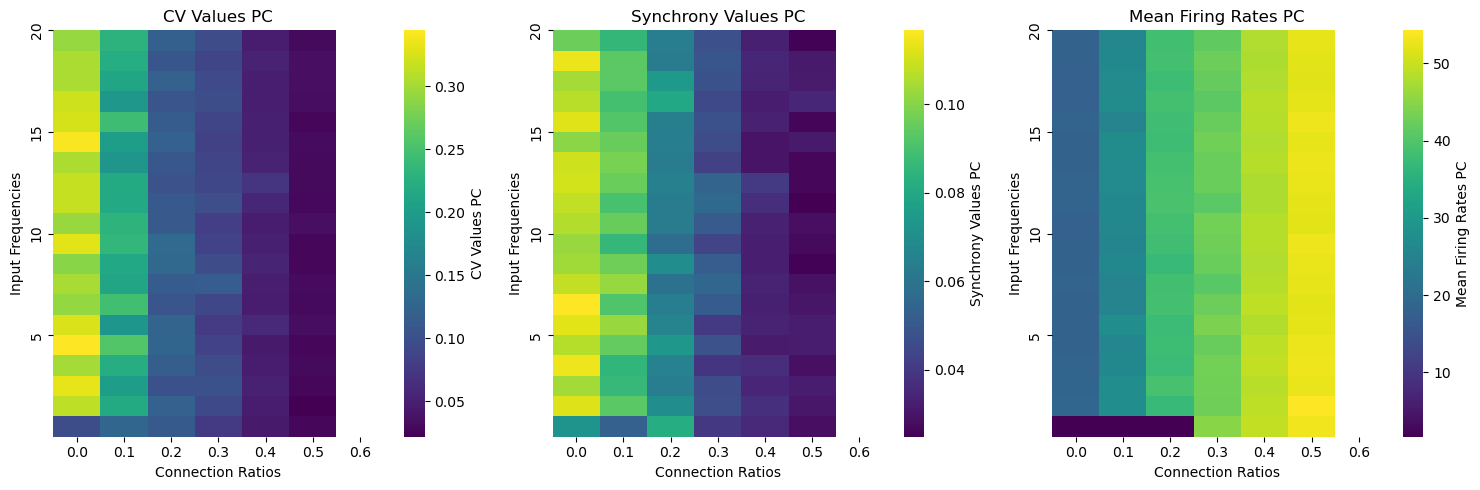

In [12]:
# Load the data
data_path = os.path.join(save_directory_path, "simulation_data.npy")
data = np.load(data_path, allow_pickle=True).item()

import seaborn as sns
# Extract the data
cv_values_pc = np.array(data['cv_values_pc']).reshape(len(data['input_frequencies']), -1)[::-1]
synchrony_values_pc = np.array(data['synchrony_values_pc']).reshape(len(data['input_frequencies']), -1)[::-1]
mean_pc_rates = np.array(data['mean_pc_rates']).reshape(len(data['input_frequencies']), -1)[::-1]

input_frequencies = data['input_frequencies'][::-1]
connection_ratios = [round(x, 1) for x in data['connection_ratios']]
y_ticks = np.arange(0, len(input_frequencies), 5)
y_ticklabels = [input_frequencies[i] for i in y_ticks]

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# CV Values PC
sns.heatmap(cv_values_pc, ax=ax[0], cmap='viridis', cbar_kws={'label': 'CV Values PC'})
ax[0].set_xticks(np.arange(len(connection_ratios)) + 0.5)
ax[0].set_xticklabels(connection_ratios)
ax[0].set_yticks(y_ticks)
ax[0].set_yticklabels(y_ticklabels)
ax[0].set_xlabel('Connection Ratios')
ax[0].set_ylabel('Input Frequencies')
ax[0].set_title('CV Values PC')

# Synchrony Values PC
sns.heatmap(synchrony_values_pc, ax=ax[1], cmap='viridis', cbar_kws={'label': 'Synchrony Values PC'})
ax[1].set_xticks(np.arange(len(connection_ratios)) + 0.5)
ax[1].set_xticklabels(connection_ratios)
ax[1].set_yticks(y_ticks)
ax[1].set_yticklabels(y_ticklabels)
ax[1].set_xlabel('Connection Ratios')
ax[1].set_ylabel('Input Frequencies')
ax[1].set_title('Synchrony Values PC')

# Mean Firing Rates PC
sns.heatmap(mean_pc_rates, ax=ax[2], cmap='viridis', cbar_kws={'label': 'Mean Firing Rates PC'})
ax[2].set_xticks(np.arange(len(connection_ratios)) + 0.5)
ax[2].set_xticklabels(connection_ratios)
ax[2].set_yticks(y_ticks)
ax[2].set_yticklabels(y_ticklabels)
ax[2].set_xlabel('Connection Ratios')
ax[2].set_ylabel('Input Frequencies')
ax[2].set_title('Mean Firing Rates PC')

plt.tight_layout()
plt.show()


In [12]:
print(np.arange(0, .7, .1))

[0.  0.1 0.2 0.3 0.4 0.5 0.6]
